<a href="https://colab.research.google.com/github/sridharnandigam/GestureRecognition/blob/metrics/human_activity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 17 14:19:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu
!pip install sklearn

     |████████████████████████████████| 516.2MB 33kB/s 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: /content/WISDM_ar_latest.tar.gz
11.4MB [00:00, 18.5MB/s]
WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [7]:
#working on uploading files easier via google drive :3
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('gesture_data.csv', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,30,waving,4.582675e+09,-0.353728,5.283476,7.901423
1,30,waving,4.588676e+09,-0.277715,5.296046,8.208766
2,30,waving,4.594678e+09,-0.277715,5.296046,8.208766
3,30,waving,4.607681e+09,-0.238512,5.258937,8.365580
4,30,waving,4.614681e+09,-0.201104,5.226916,8.395206


In [ ]:
df.shape

(131205, 6)

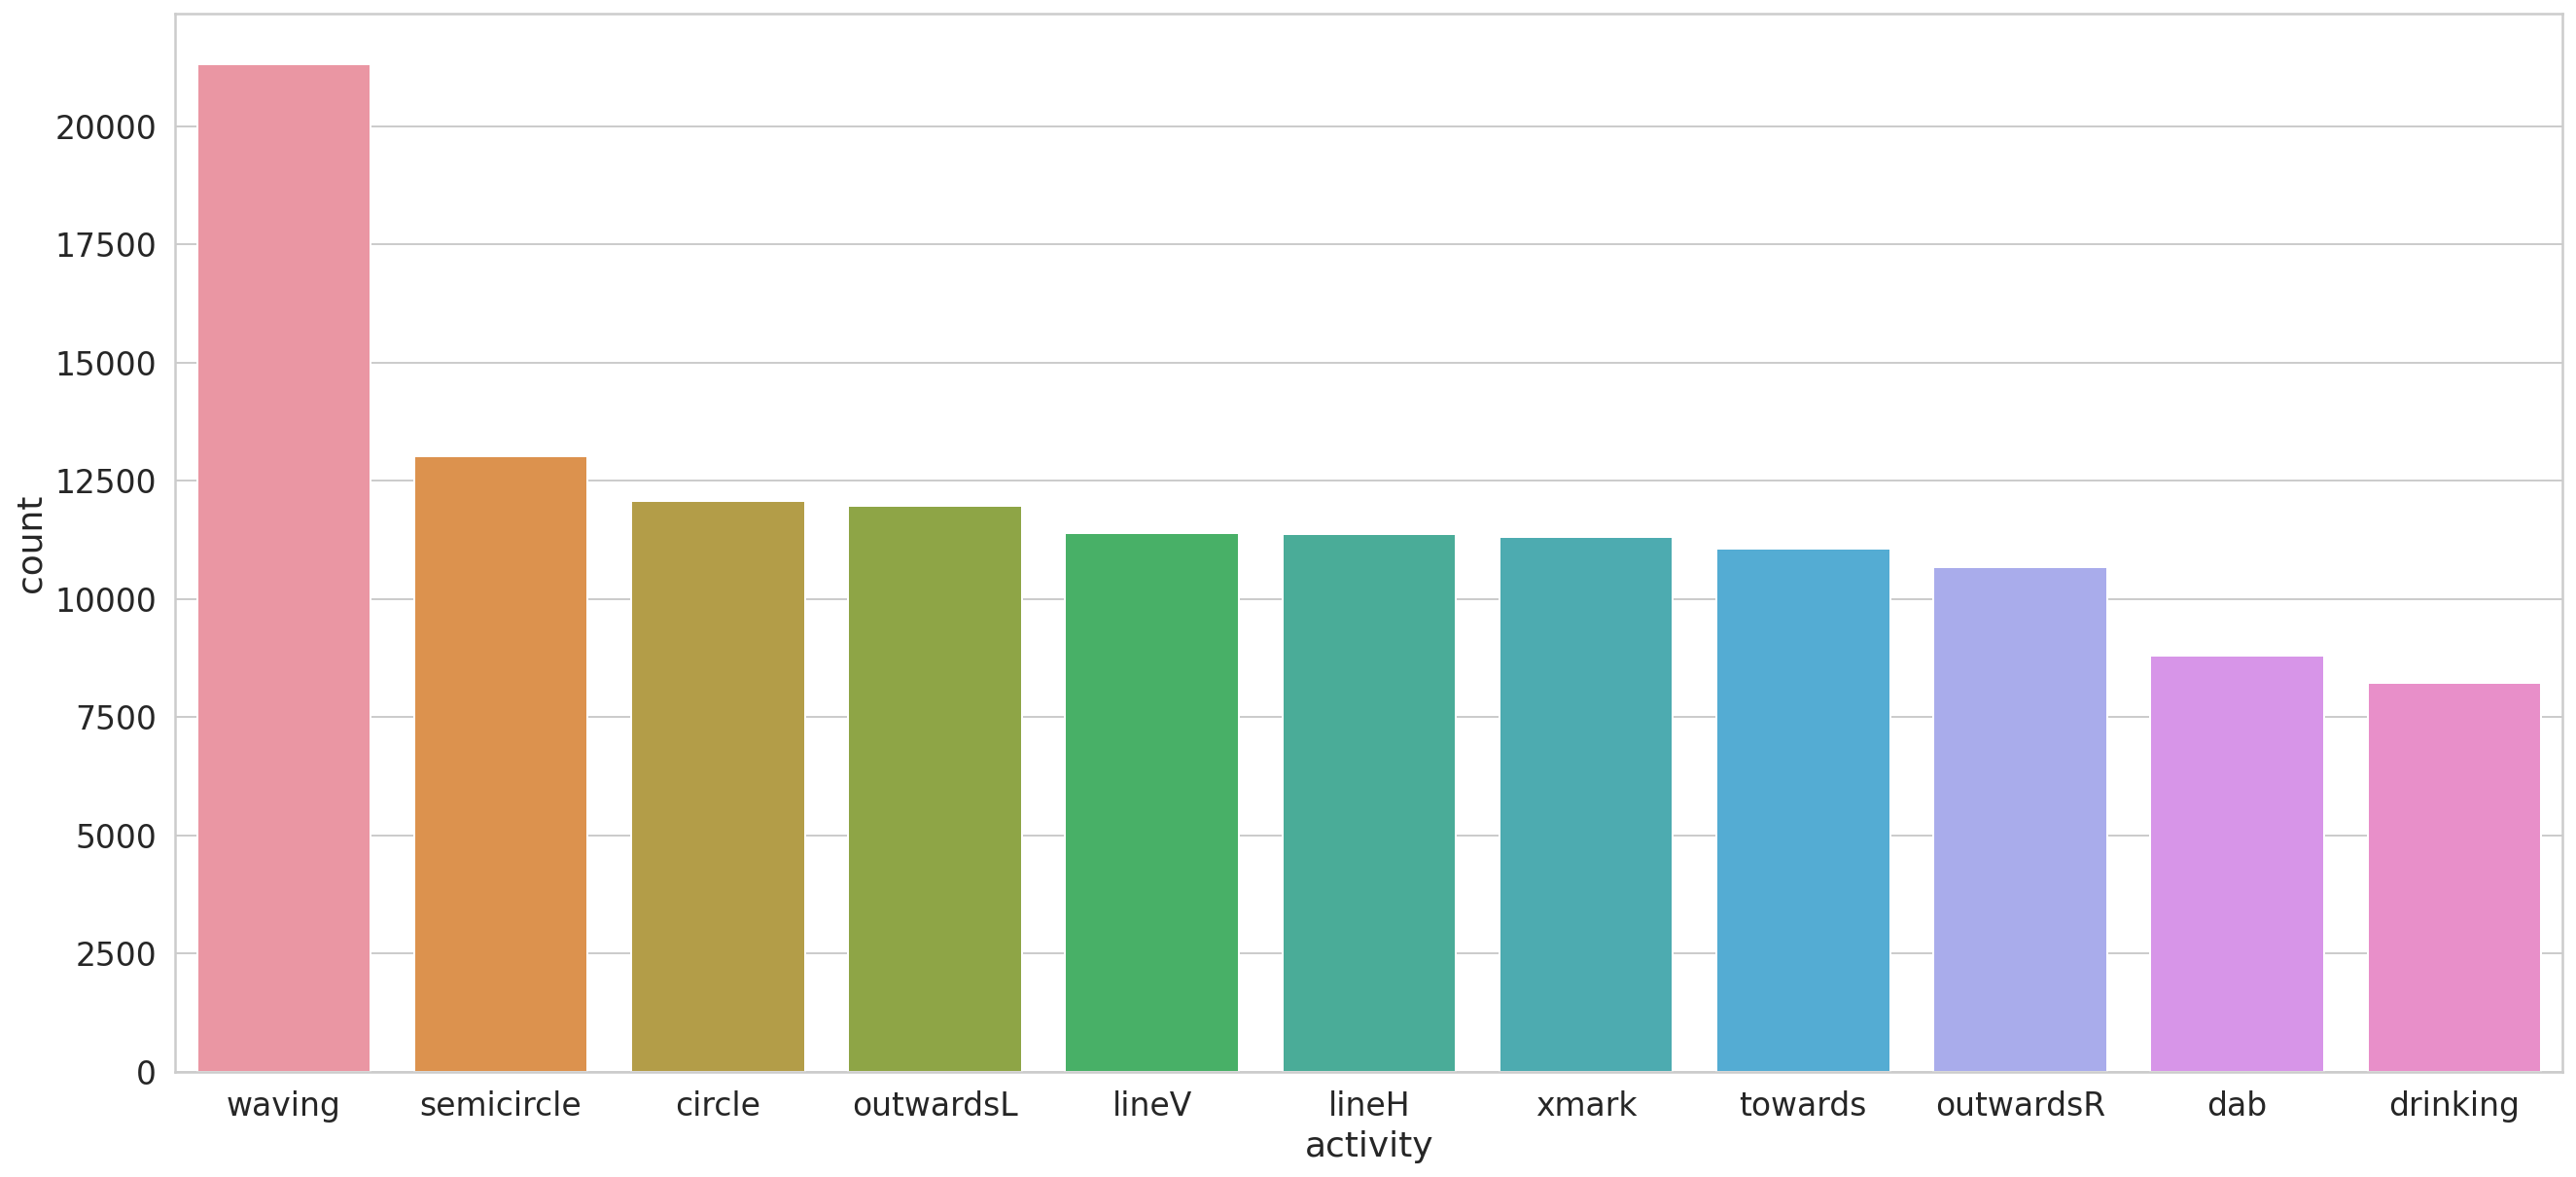

In [ ]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

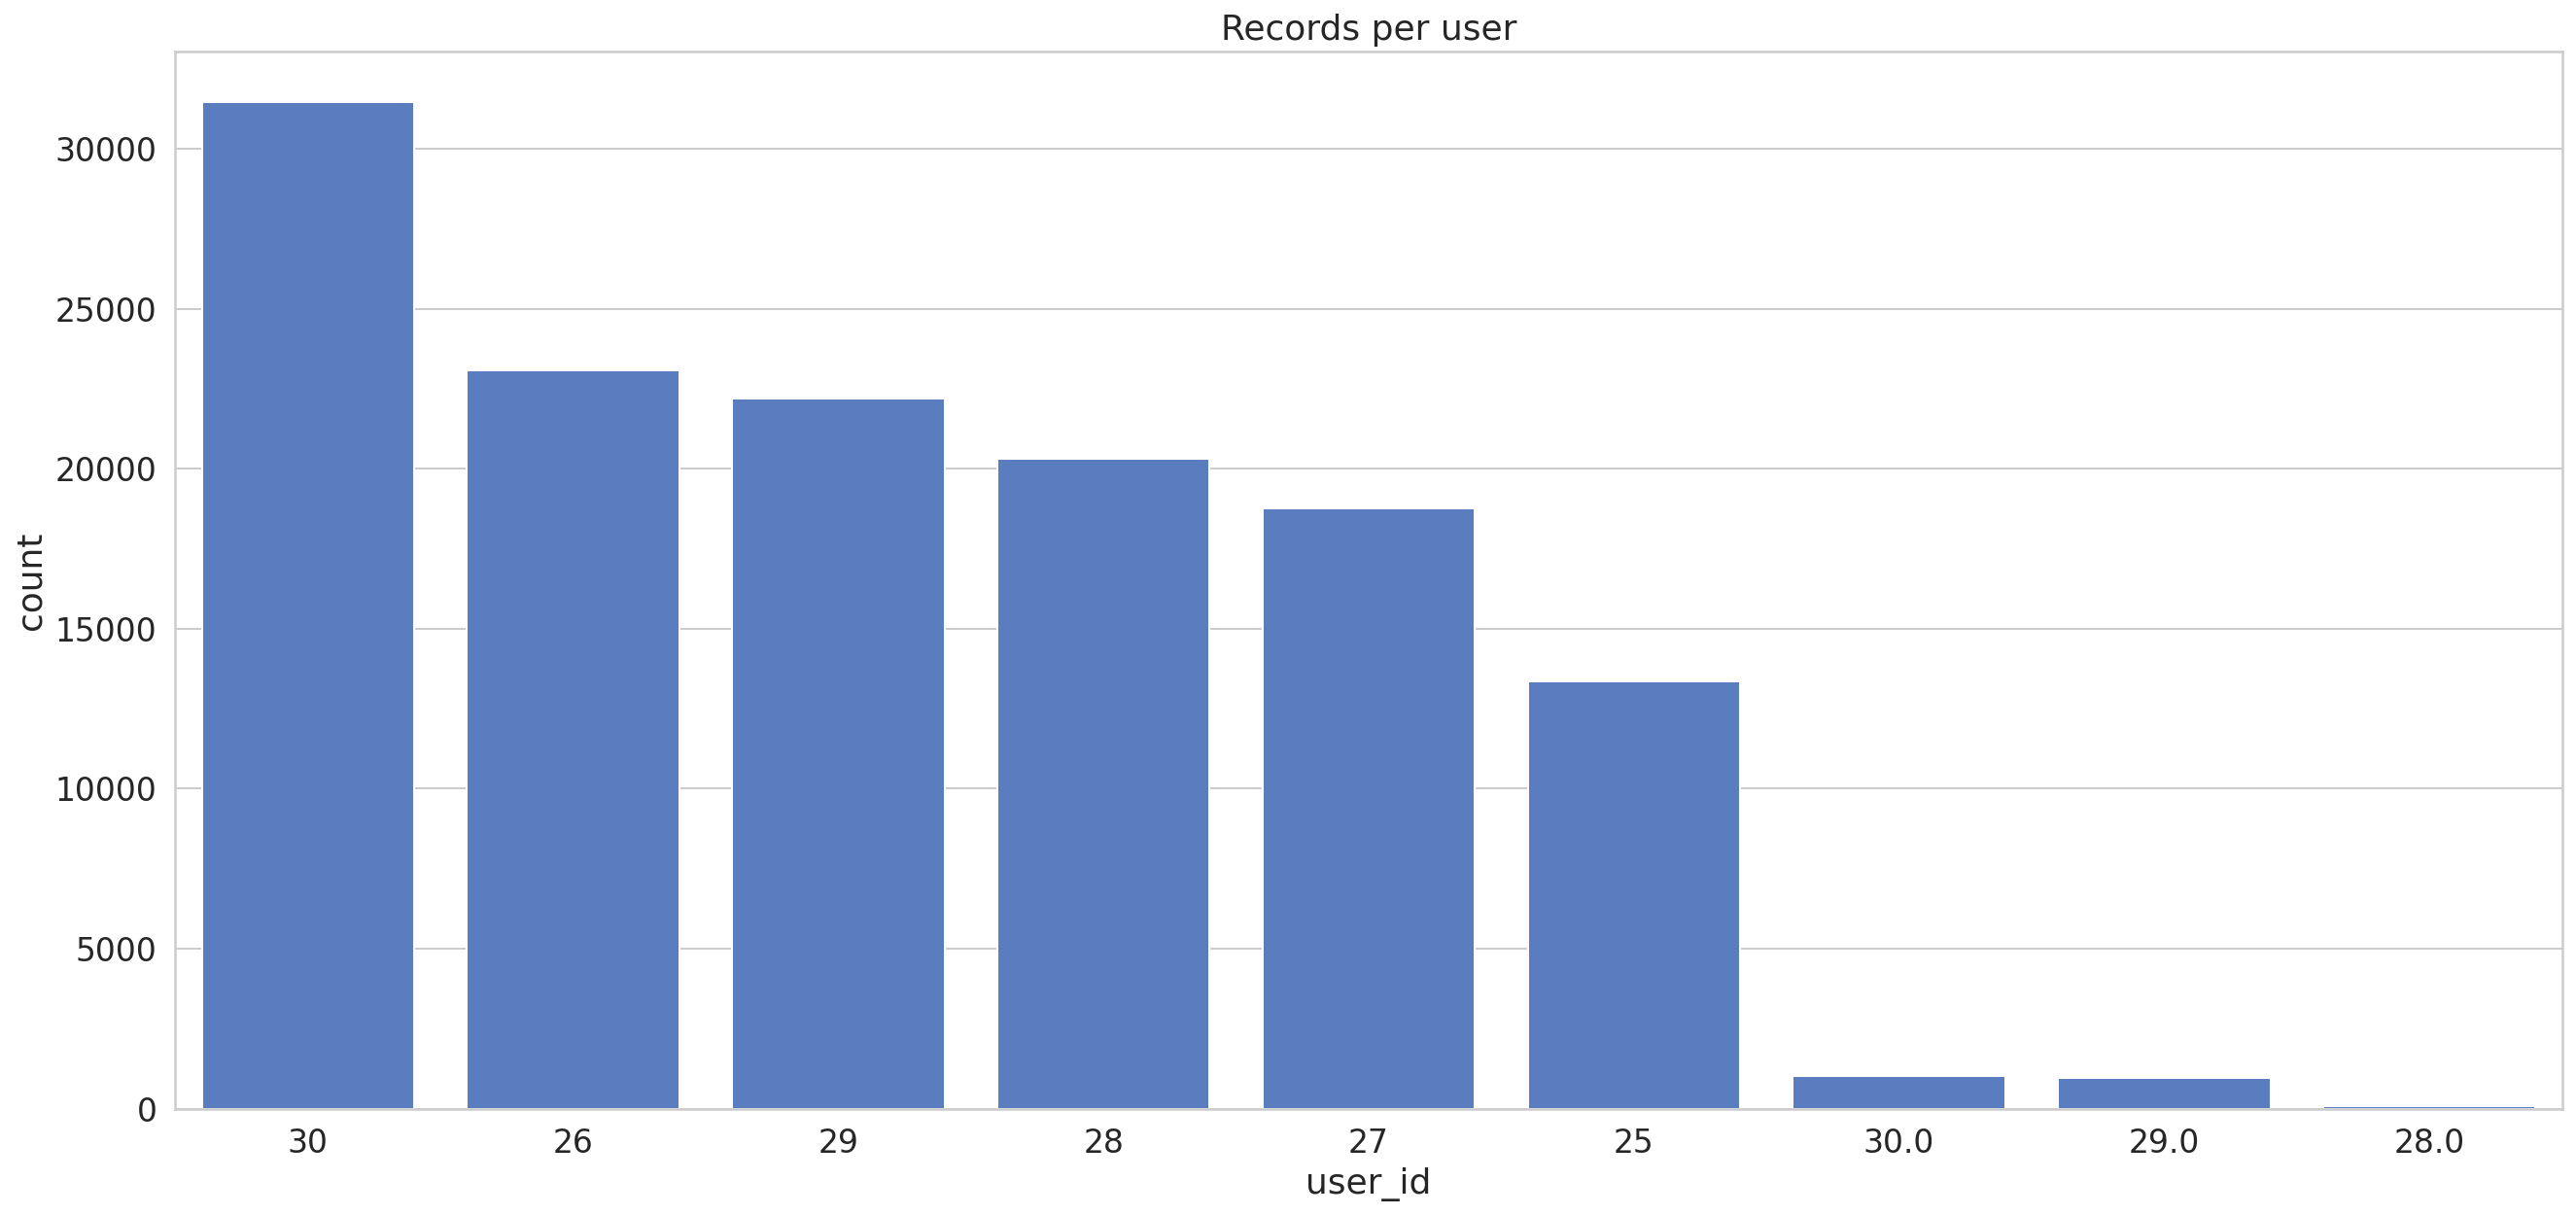

In [ ]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [10]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

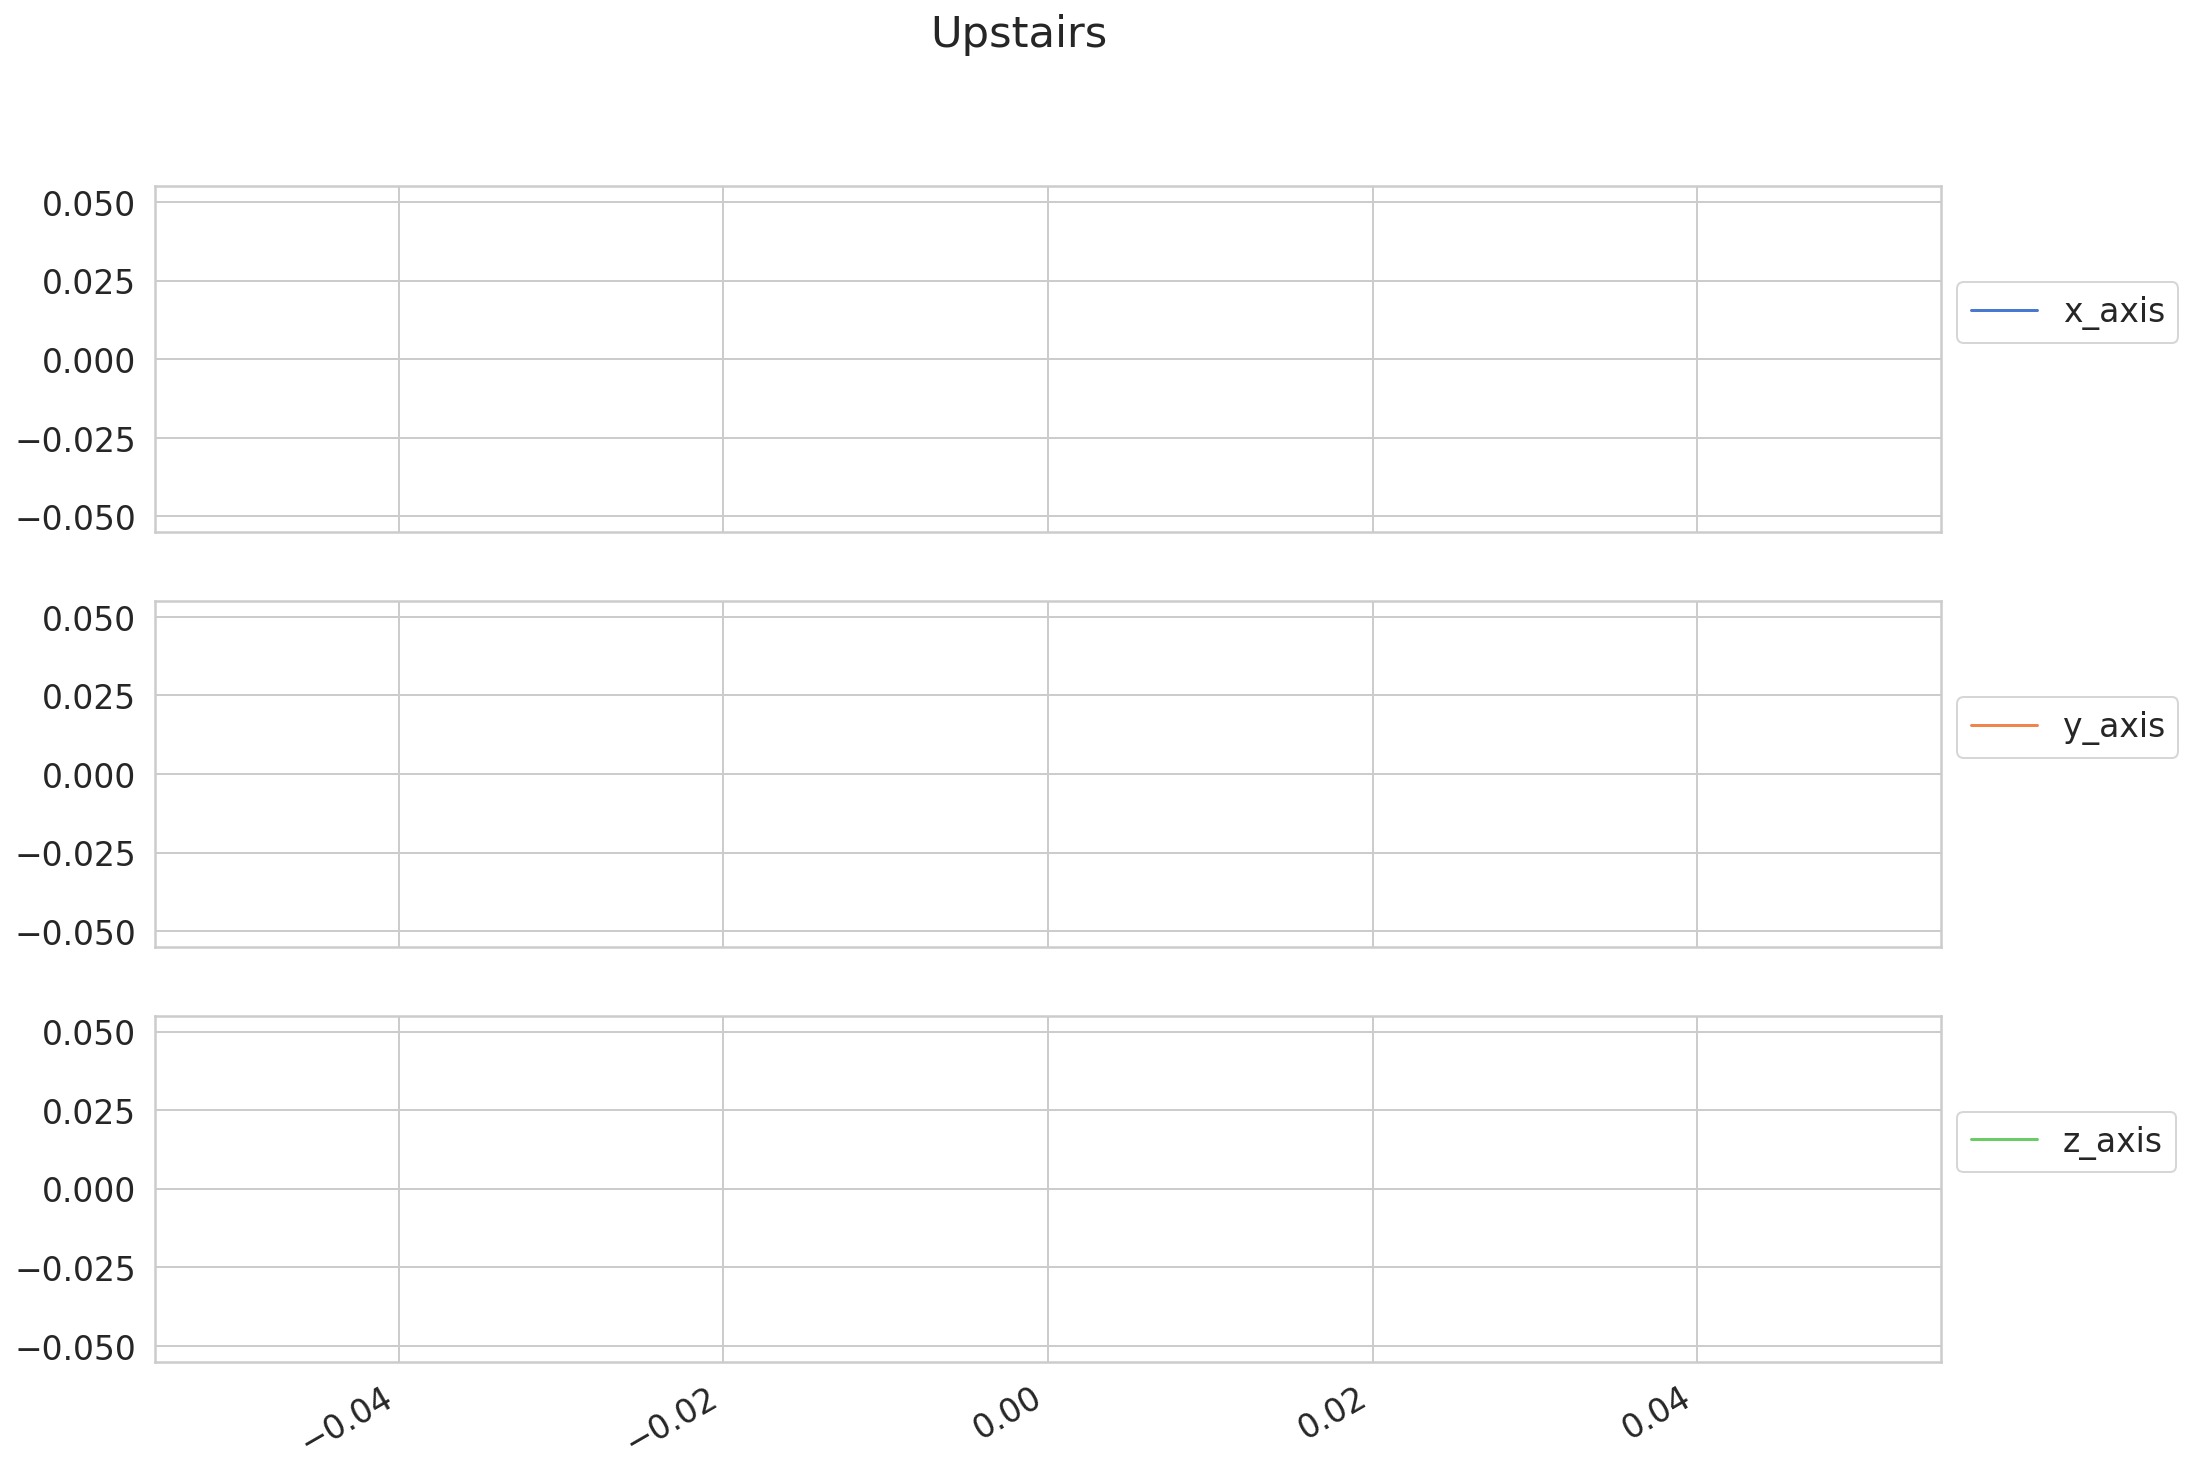

In [ ]:
plot_activity("Upstairs", df);

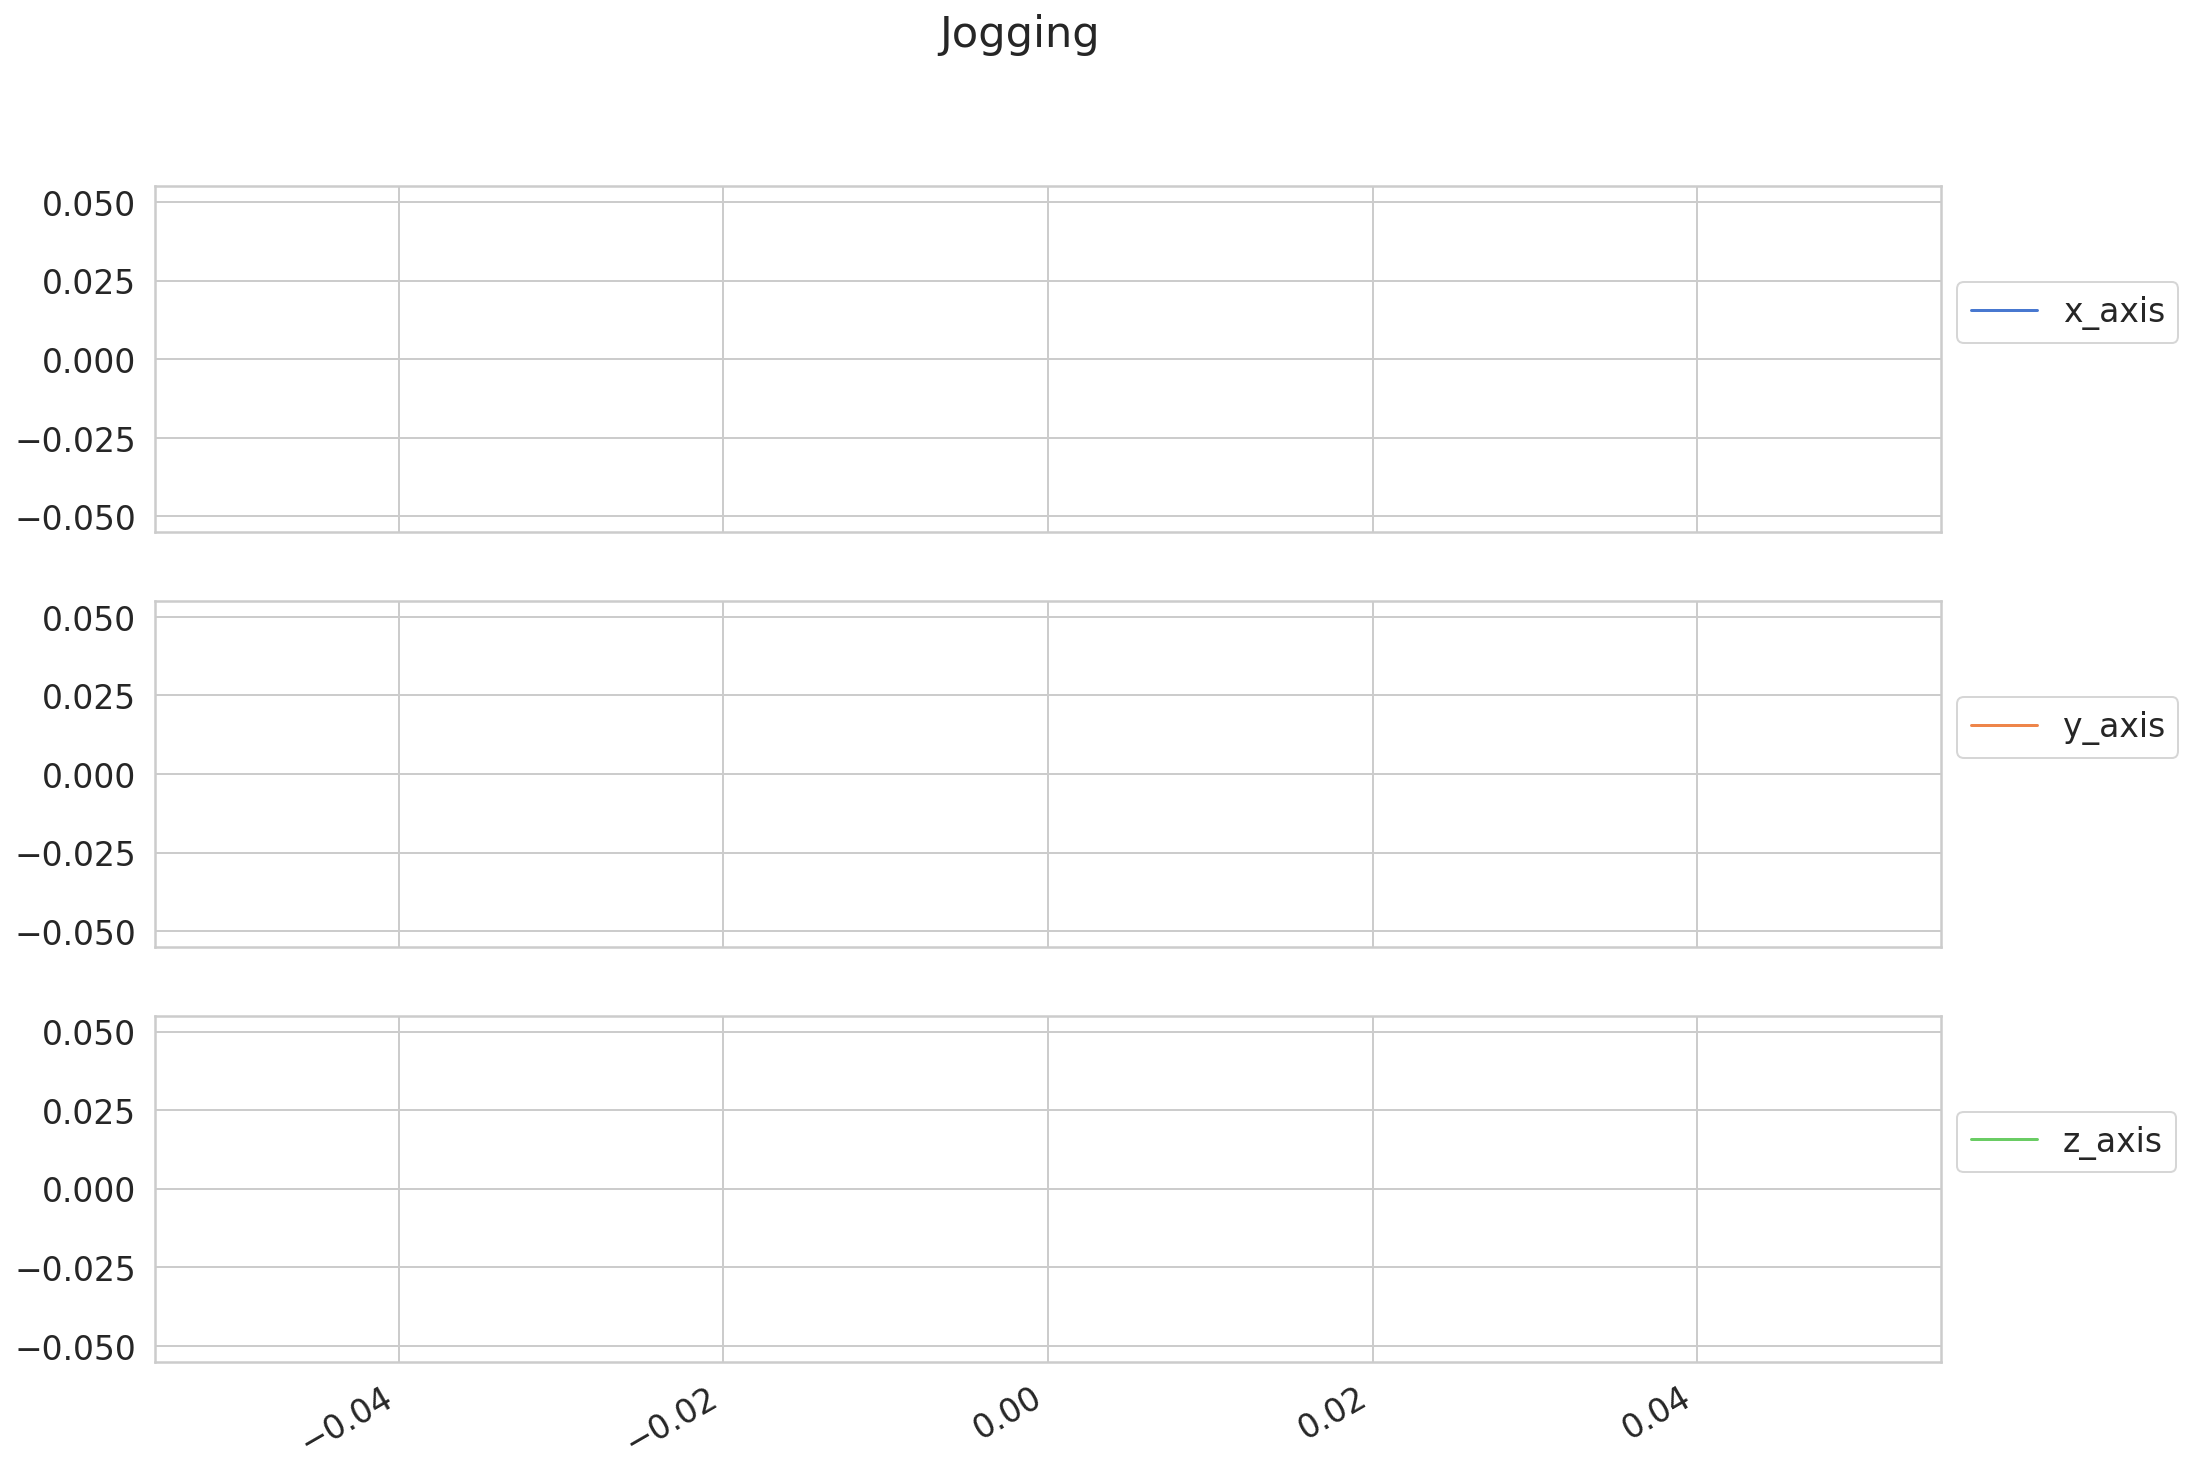

In [ ]:
plot_activity("Jogging", df);

In [6]:
df['user_id'] = df['user_id'].astype(int)
df_train = df[df['user_id'] > 26]
df_test = df[df['user_id'] <= 26]

In [ ]:
df_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
14780,26,waving,2.625991e+09,0.391435,4.025677,8.900661
14781,26,waving,2.668957e+09,0.390837,3.978394,8.961112
14782,26,waving,2.717996e+09,0.427945,3.885323,8.975475
14783,26,waving,2.768635e+09,0.330583,3.975102,8.941061
14784,26,waving,2.835383e+09,0.287890,3.983780,8.927295


In [7]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [9]:
print(X_train.shape, y_train.shape)

#Added code to save raw array before one hot encoding

raw_ytrain = y_train
raw_ytest = y_test

(2365, 200, 3) (2365, 1)


In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [14]:
print(X_train.shape, y_train.shape)

(2365, 200, 3) (2365, 11)


In [25]:
#testing recall and precision, ignore for now
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

34/34 [==============================] - 4s 123ms/step - loss: 1.7918 - acc: 0.4004 - val_loss: 3.6563 - val_acc: 0.0042
Epoch 2/30
34/34 [==============================] - 3s 87ms/step - loss: 1.1448 - acc: 0.5639 - val_loss: 4.2132 - val_acc: 0.0000e+00
Epoch 3/30
34/34 [==============================] - 3s 87ms/step - loss: 1.0890 - acc: 0.5738 - val_loss: 4.5751 - val_acc: 0.0000e+00
Epoch 4/30
34/34 [==============================] - 3s 86ms/step - loss: 1.0475 - acc: 0.5921 - val_loss: 

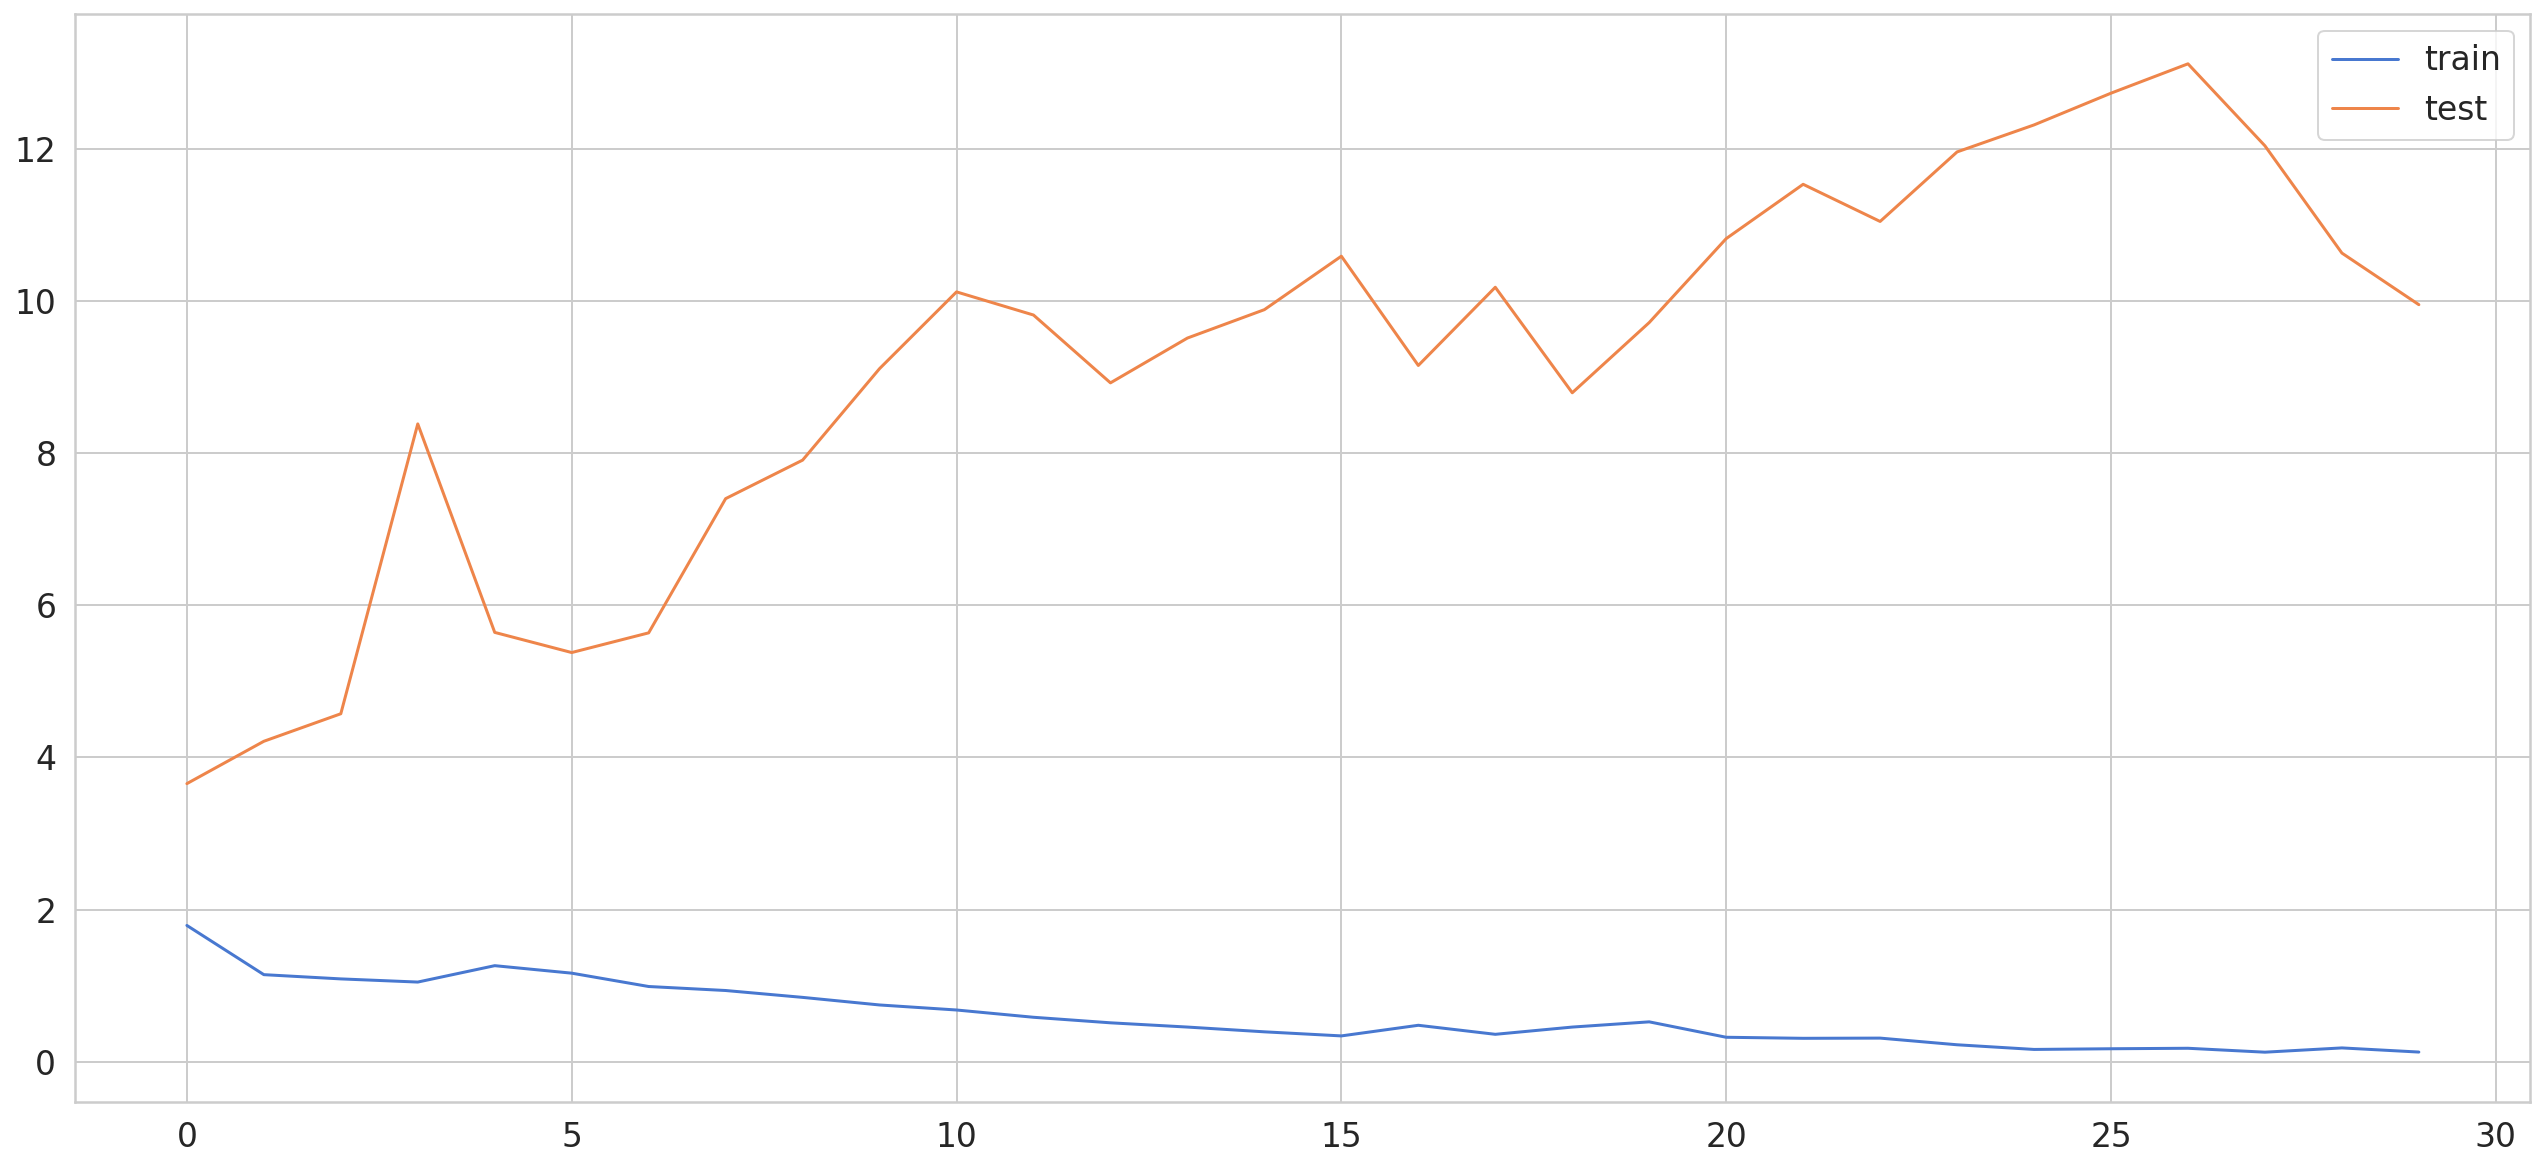

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 1s 35ms/step - loss: 1.0223 - acc: 0.8477


[1.0222837924957275, 0.8476821184158325]

In [15]:
y_pred = model.predict(X_test)
y_classes = model.predict_classes(X_test)

ytest_transf = enc.inverse_transform(y_test)
ytest_pred = enc.inverse_transform(y_pred)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred_dim = y_pred[:, 0]
#y_classes_dim = y_classes[:, 0]
y_true_dim = y_test[:, 0]

#accuracy = accuracy_score(raw_ytest, y_classes)

classification_report(y_true_dim, y_pred_dim)

ValueError: ignored

In [19]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(21, 19)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(230, 30, n=9),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names, rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

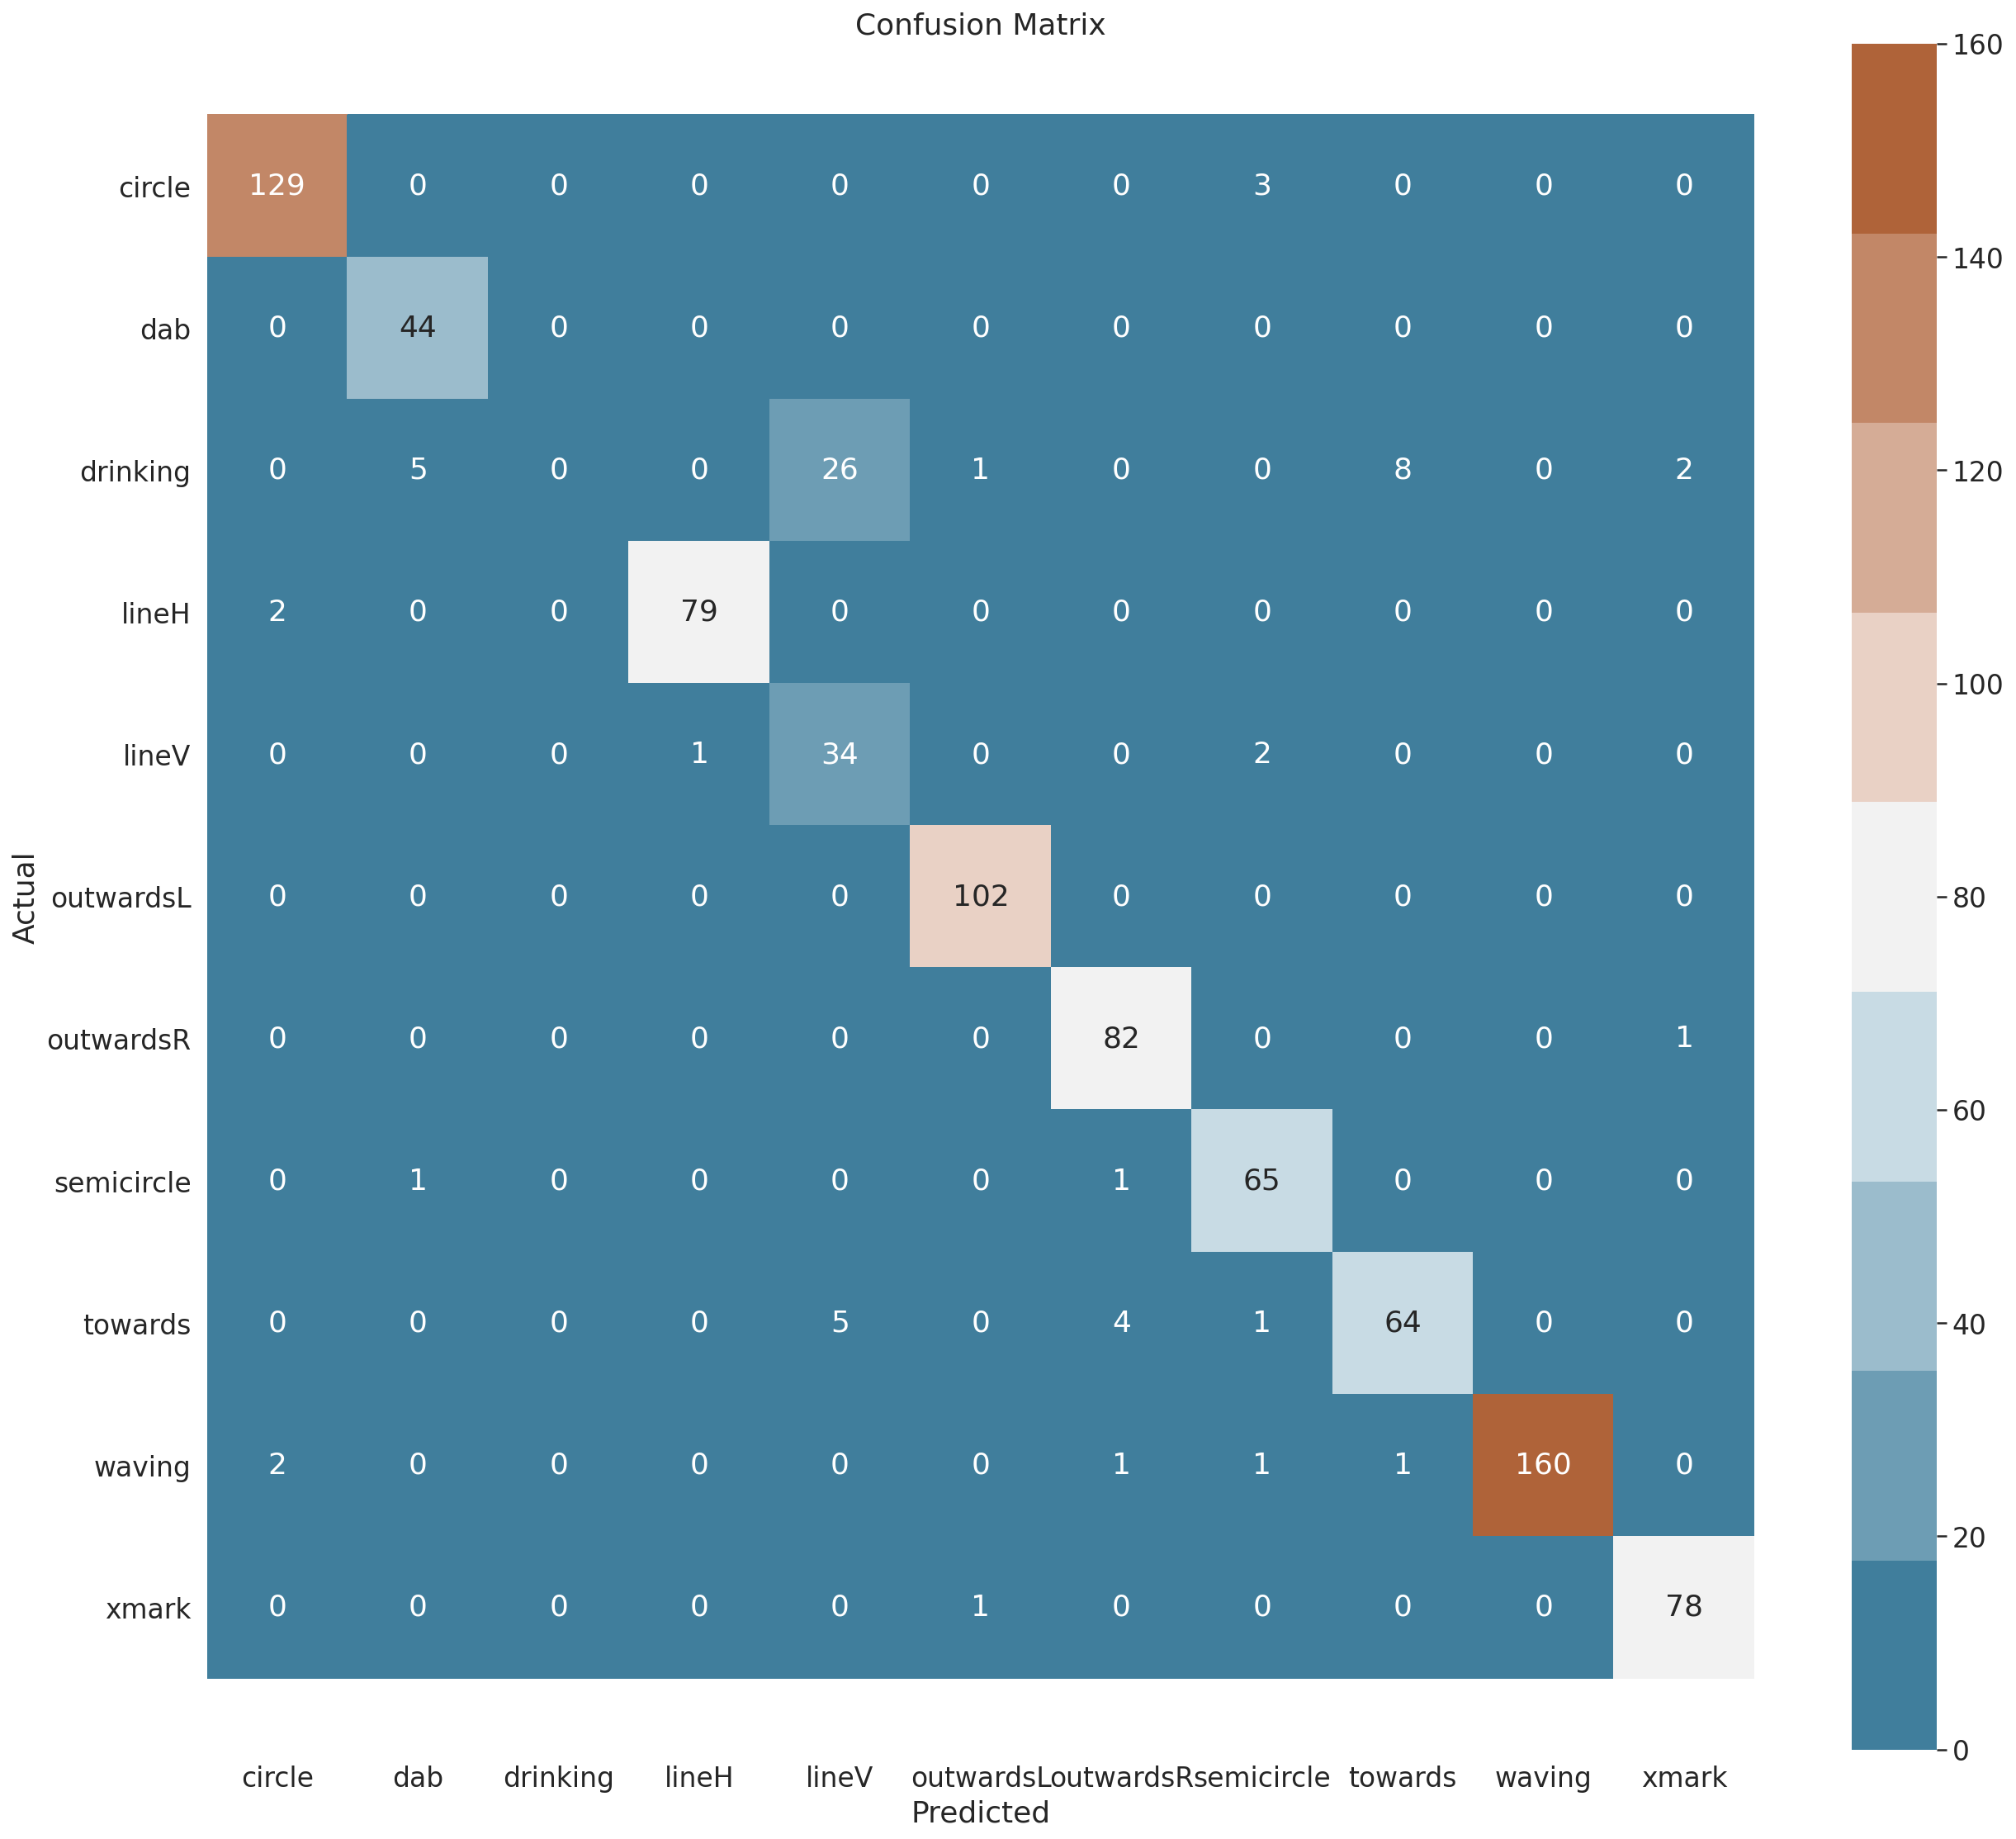

In [ ]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)